In [288]:
import sys
import subprocess
import requests
import cixcerts
from cdf.auth import get_iam_token
import getpass
import pandas as pd
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors,Descriptors
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.PropertyMol import *
from rdkit.Chem import SDWriter
import json
import numpy as np
from IPython.core.display import HTML

In [289]:
IPythonConsole.ipython_useSVG = True

In [290]:
def result_to_dataframe(json_result: str) -> pd.DataFrame:
    """ Converts JSON output to pd.DataFrame """
    records = []
    for entry in json_result["result"]:
        buildingblock = entry["BuildingBlock"]
        for variant in buildingblock["Variants"]:
            row = {
                **{k:v for (k,v) in buildingblock.items() if k != "Variants"},
                **variant
            }
            records.append(row)
    # results
    df = pd.DataFrame.from_records(records)
    return df

In [291]:
class ClientConfig:
    def __init__(
        self,
        username: str,
        password: str
    ):
        self.token = get_iam_token(
            user=username,
            password=password
        )
        self.cert = cixcerts.pem
        self.proxies = {
            "http": "http://nibr-proxy.global.nibr.novartis.net:2011",
            "https": "http://nibr-proxy.global.nibr.novartis.net:2011"
        }
        self.base_url = "https://daid-building-blocks.dev.nibr.novartis.net"
        
        self.headers = {
            "Content-Type": "application/json",
            "accept": "application/json"
        }
        
class Client:
    def __init__(
        self,
        config: ClientConfig,
    ):
        self.config = config
        
    def search(self, json_query) -> str:
        url = f"{self.config.base_url}/api/building_block/search"
        
        try:
            r = requests.post(
                url, 
                json=json_query, 
                #proxies=self.config.proxies, 
                verify=None,#self.config.cert,
                #headers=self.config.headers,
                cookies={
                    "ObSSOCookie": self.config.token,
                },
            )
            r.raise_for_status()
        except requests.exceptions.HTTPError as e:
            print(e.response.text)
            raise(e)
        return r.json()

In [292]:
from rdkit.Chem.FilterCatalog import *
functional_groups = GetFlattenedFunctionalGroupHierarchy()

In [293]:
def count_components(mol):
    ctr = 0
    mol_frags = AllChem.GetMolFrags(mol)
    for frag in mol_frags:
        ctr += 1
    return ctr

def count_functional_group(mol, functional_group):
    ctr = 0
    for match in mol.GetSubstructMatches(functional_group):
        ctr += 1
    return ctr

In [294]:
functional_groups['amidine'] = AllChem.MolFromSmarts('[NX3][CX3](=[NX1])')
functional_groups['amide.primary'] = AllChem.MolFromSmarts('[NX3;H2][CX3](=[OX1])[#6]')
functional_groups['amide.secondary'] = AllChem.MolFromSmarts('[#6][NX3;H1][CX3](=[OX1])[#6]')
functional_groups['amide.tertiary'] = AllChem.MolFromSmarts('[#6][NX3;H0]([#6])[CX3](=[OX1])[#6]')
functional_groups['aniline'] = AllChem.MolFromSmarts('[NX3][$(cc)]')
functional_groups['aniline.primary'] = AllChem.MolFromSmarts('[NX3;H2][$(cc)]')
functional_groups['aniline.secondary'] = AllChem.MolFromSmarts('[NX3;H][$(cc)]')
functional_groups['anhydride'] = AllChem.MolFromSmarts('CC(CC(C)=O)=O')
functional_groups['azo'] = AllChem.MolFromSmarts('[NX2]=[NX2]')
functional_groups['bromine'] = AllChem.MolFromSmarts('[Br]')
functional_groups['bromine.aromatic'] = AllChem.MolFromSmarts('[Br]a')
functional_groups['disulfide'] = AllChem.MolFromSmarts('[#16X2][#16X2]')
functional_groups['enamime'] = AllChem.MolFromSmarts('[NX3][$(C=C)]')
functional_groups['hydrazine'] = AllChem.MolFromSmarts('[NX3][NX3]')
functional_groups['hydroxylamine'] = AllChem.MolFromSmarts('[N;H1][O]')
functional_groups['iodine'] = AllChem.MolFromSmarts('[I]')
functional_groups['phosphorus'] = AllChem.MolFromSmarts('[P]')
functional_groups['silicon'] = AllChem.MolFromSmarts('[Si]')
functional_groups['sulfonamide'] = AllChem.MolFromSmarts('[N]-[S]')
functional_groups['sulfonicacid'] = AllChem.MolFromSmarts('[O;H][S](=O)(=O)')
functional_groups['thioketone'] = AllChem.MolFromSmarts('[#6][CX3](=S)[#6]')
functional_groups['thiol'] = AllChem.MolFromSmarts('[#16X2H]')
functional_groups['hydroxy.aliphatic'] = AllChem.MolFromSmarts('[OX2;H1][CX4]')
functional_groups['hydroxy.aromatic'] = AllChem.MolFromSmarts('[OX2;H1]c')
functional_groups['chloro.sp3'] = AllChem.MolFromSmarts('[Cl]-C')
functional_groups['chloro.sp2'] = AllChem.MolFromSmarts('[Cl]-[$([cX3](:*):*),$([cX2+](:*):*),$([CX3]=*),$([CX2+]=*)]')
functional_groups['het.carbon.het'] =  AllChem.MolFromSmarts('[A]-[N,O,S]-[CX4]-[N,O,S]-[A]')
functional_groups['nitrogen-halogen'] = AllChem.MolFromSmarts('[#7]-[F,Cl,Br,I]')
functional_groups['S-S'] = AllChem.MolFromSmarts('[#16]-[#16]')

# these are for exclusions
functional_groups['sodium'] = AllChem.MolFromSmarts('[Na]')
functional_groups['arsenic'] = AllChem.MolFromSmarts('[As]')
functional_groups['selenium'] = AllChem.MolFromSmarts('[Se]')

functional_groups['ester'] = AllChem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]')
functional_groups['ketone'] = AllChem.MolFromSmarts('[#6][CX3](=[OX1])[#6]')
functional_groups['epoxide'] = AllChem.MolFromSmarts('[#6]-1-[#6]-[#8]-1')

functional_groups['alcohol.primary'] = AllChem.MolFromSmarts('[#6][CH2][OH]')
functional_groups['alcohol.secondary'] = AllChem.MolFromSmarts('[#6][CH]([#6])[OH]')
functional_groups['alcohol.tertiary'] = AllChem.MolFromSmarts('[#6][C]([#6])([#6])[OH]')
functional_groups['alcohol.phenol'] = AllChem.MolFromSmarts('c[OH]')

functional_groups['alkene']=AllChem.MolFromSmarts('[C]=[C]')
functional_groups['terminal_alkene']=AllChem.MolFromSmarts('[C]=[C;H2]')
functional_groups['alkyne']=AllChem.MolFromSmarts('C#C')

functional_groups['NCO2H']=AllChem.MolFromSmarts('[#7]-[CX3](-[#8;H1])=O')
functional_groups['sulfonylfluoride']=AllChem.MolFromSmarts('[$(S-&!@[#6])](=O)(=O)-,:F')
functional_groups['methylamino_acrylate']=AllChem.MolFromSmarts('[CX4]-[#8]-[CX3](=O)\\[#6&X3]=[#6&X3]\\[N]')
functional_groups['acetal']=AllChem.MolFromSmarts('[#8X2]-[CX4]-[#8X2]')
functional_groups['cyanamido']=AllChem.MolFromSmarts('[N]C#N')
functional_groups['Nitrile'] = AllChem.MolFromSmarts('[CX2]#[NX1]')

functional_groups['diazarine'] = AllChem.MolFromSmarts('[#7]~1~[#7]~[#6]~1')
functional_groups['aziridine'] = AllChem.MolFromSmarts('[#7]-1-[#6]-[#6]-1')
functional_groups['acrylamide'] = AllChem.MolFromSmarts('[#7]-[#6](=[O])-[#6]=[#6]')
functional_groups['acyl_chloride'] = AllChem.MolFromSmarts('[#6](=[O])-[Cl]')
functional_groups['deuterium'] = AllChem.MolFromSmarts('[2#1]')
functional_groups['tritium'] = AllChem.MolFromSmarts('[3#1]')
functional_groups['NO'] = AllChem.MolFromSmarts('[N]-[O]')
functional_groups['C11'] = AllChem.MolFromSmarts('[11#6]')
functional_groups['C13'] = AllChem.MolFromSmarts('[13#6]')
functional_groups['CSOC'] = AllChem.MolFromSmarts('[#6]-[S,O1]([O])-[#6]')
functional_groups['thioamide'] = AllChem.MolFromSmarts('[N][CX3](=[SX1])[#6]')
functional_groups['thiolate'] = AllChem.MolFromSmarts('[SH]')

functional_groups['tBOC'] = AllChem.MolFromSmarts('[CH3]C([CH3])([CH3])[#8]-[#6](-[#7])=O')

#functional_groups['tBOC'] = AllChem.MolFromSmarts('[CH3]C([CH3])([CH3])[#8]-[#6](-[N&D3&$(N(-[#6])(-[#6])-[#6])])=O')
#functional_groups['Fmoc'] = AllChem.MolFromSmarts('[N&D3&$(N(-[#6])(-[#6])-[#6])]-[#6](=O)-[#8]-[#6]-[#6]~1~[#6]~2~[#6](~[c;H1]~[c;H1]~[c;H1]~[c;H1]~2)~[#6]~2~[#6]~1~[c;H1]~[c;H1]~[c;H1]~[c;H1]~2')
#functional_groups['CBz'] = AllChem.MolFromSmarts('[N&D3&$(N(-[#6])(-[#6])-[#6])]-[#6](=O)-[#8]-[C;H2]-[c]~1~[c;H1]~[c;H1]~[c;H1]~[c;H1]~[c;H1]~1')

# reaction to deprotect tBOC
# deprotect_rxn_string = "[N:1]C(=O)OC([CH3])([CH3])([CH3])>>[N:1]"

In [295]:
def set_query(smarts_str):
    
    json_query = {
    "search": {
        "kind": "smarts",
        "attribute": "atdb",
        "value": smarts_str,
        "operator": "equals",
    },
    "limit": 10000,
    "offset": 0
    }
    
    return json_query

# Uncomment and add your credentials

In [296]:
user = input('Username: ')

Username: dicksca3


In [297]:
pw = getpass.getpass('Password: ')

Password: ········


In [298]:
config = ClientConfig(username=user, password=pw)
client = Client(config)

In [299]:
AllChem.MolToSmarts(functional_groups['ketone'])

'[#6][C&X3](=[O&X1])[#6]'

# Query for building block reagents via SMARTS pattern

In [300]:
result = client.search(set_query('[#6][C&X3](=[O&X1])[#6]'))
df=result_to_dataframe(result)

In [301]:
len(df)

16624

In [302]:
list(df.columns)

['smiles',
 'id',
 'catalogue',
 'vendor',
 'location',
 'order_information',
 'system',
 'site',
 'amount',
 'amount_unit',
 'concentration',
 'concentration_unit',
 'salt']

### Next steps put dataframe into easier format, personal preference

In [303]:
df['site_generic'] = np.where(df['site'].str.lower()=='ext', 'External', 'NIBR')

In [304]:
# put internal BBs first
df=df.sort_values(by=['site_generic'],ascending=[False])

In [305]:
df=df.dropna(subset=['smiles'])

In [306]:
df=df.drop_duplicates(subset=['smiles'])
df=df.reset_index(drop=True)

In [307]:
df.head()

,smiles,id,catalogue,vendor,location,order_information,system,site,amount,amount_unit,concentration,concentration_unit,salt,site_generic
0,CC12CCC(=O)C=C1C[C@@H](O)C1C2CCC2(C)C1CC[C@@]2...,7879343608656521717,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,13497392,SMF,CHBS,62.3,mg,None,None,False,NIBR
1,C[C@]12CCC(=O)C=C1CCC1C2[C@H](O)C[C@@]2(C)C1CC...,1296419637511786997,Novartis Compound HUB Powders,Novartis,CHC 4C Store Basel,13578343,SMF,CHBS,213.0,mg,None,None,False,NIBR
2,C[C@]12C=CC(=O)C=C1CCC1C2[C@@H](O)C[C@]2(C)/C(...,4088587590609636338,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-1 Basel,14608834,SMF,CHBS,52.1,mg,None,None,False,NIBR
3,C[C@]12C=CC(=O)C=C1CCC1C2[C@@H](O)C[C@@]2(C)C1...,8179410066452163574,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-1 Basel,13956479,SMF,CHBS,25.4,mg,None,None,False,NIBR
4,C[C@]12C=CC(=O)C=C1CCC1C2[C@@H](O)C[C@@]2(C)C1...,9189497270687683842,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-1 Basel,10345825,SMF,CHBS,132.0,mg,None,None,False,NIBR


In [308]:
len(df)

10000

# Define the scaffold to react with

In [309]:
scaffold = AllChem.MolFromSmiles('C(C1CCNCC1)C1=CC=CC=C1')

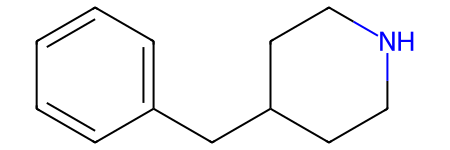

In [310]:
scaffold

In [311]:
PandasTools.AddMoleculeColumnToFrame(df,'smiles','BB_ROMol')

In [312]:
df=df.dropna(subset=['BB_ROMol'])

## Count functional groups present in building blocks

In [313]:
for functional_group in sorted(functional_groups.keys(), key=lambda x:x.lower()):
       df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))

/tmp/ipykernel_21186/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))
/tmp/ipykernel_21186/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['count_%s' % functional_group] = df['BB_ROMol'].apply(lambda mol: count_functional_group(mol, functional_groups[functional_group]))
/tmp/ipykernel_21186/494713681.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is 

## Can filter building blocks by presence of functional groups

In [314]:
# Remove some groups
df=df[df['count_Aldehyde']==0]
#df=df[df['count_ketone']==0]

df=df[df['count_ketone']==1]

df=df[df['count_Azide']==0]
df=df[df['count_NCO2H']==0]
df=df[df['count_BoronicAcid']==0]
df=df[df['count_hydrazine']==0]
df=df[df['count_Nitro']==0]
df=df[df['count_Isocyanate']==0]
df=df[df['count_phosphorus']==0]
df=df[df['count_silicon']==0]
df=df[df['count_arsenic']==0]
df=df[df['count_sodium']==0]
df=df[df['count_selenium']==0]
df=df[df['count_S-S']==0]
df=df[df['count_deuterium']==0]
df=df[df['count_epoxide']==0]
df=df[df['count_tritium']==0]
df=df[df['count_diazarine']==0]
df=df[df['count_aziridine']==0]
df=df[df['count_acrylamide']==0]
df=df[df['count_acetal']==0]
df=df[df['count_cyanamido']==0]
df=df[df['count_terminal_alkene']==0]
df=df[df['count_ester']==0]
df=df[df['count_acyl_chloride']==0]
df=df[df['count_C11']==0]
df=df[df['count_C13']==0]
df=df[df['count_CSOC']==0]
df=df[df['count_NO']==0]
df=df[df['count_thioamide']==0]
df=df[df['count_thiolate']==0]


In [315]:
df=df.reset_index(drop=True)

In [316]:
len(df)

5628

/usr/prog/scicomp/pythonds/v1.4/pyds_v1.4/lib/python3.10/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 50. Change the maxMols value to display more.
  warnings.warn(


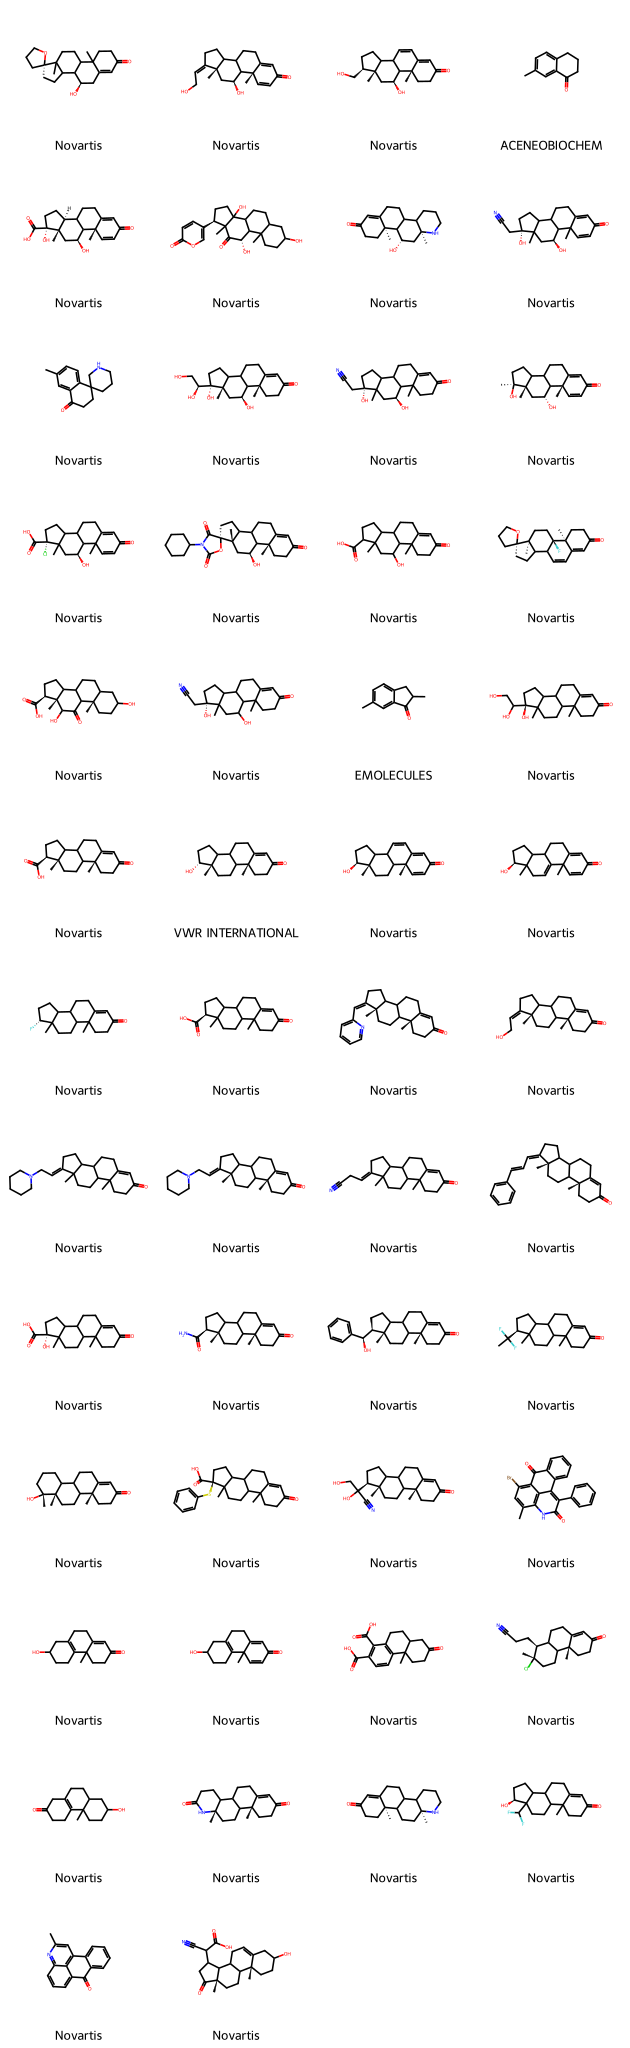

In [317]:
PandasTools.FrameToGridImage(df,column='BB_ROMol',legendsCol='vendor',molsPerRow=4,subImgSize=(200,200))


## This next section reacts the building blocks with the scaffold of interest.

### Define the Reaction SMARTS to perform a simple amide-coupling.

In [318]:
rxn_ketone = AllChem.ReactionFromSmarts('[N&H1&D2:1].[CX3;!$(C(=O)S);!$(C(=O)O);!$(C(=O)N);!$(C(=O)Cl):2](=[OX1])>>[N:1][*:2]')


In [319]:
rxn_aldehyde = AllChem.ReactionFromSmarts('[N&H1&D2:1].[CX3H;!$(C(=O)S);!$(C(=O)O);!$(C(=O)N);!$(C(=O)Cl):2](=[OX1])>>[N:1][*:2]')


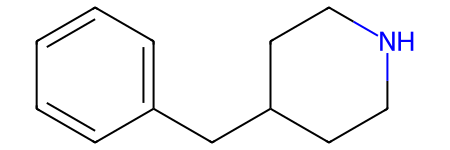

In [320]:
scaffold

# Run the enumeration

In [321]:
df['PRODUCT_SMILES']=None
for index, row in df.iterrows():
    
    bb_mol=row['BB_ROMol']
    
    try:
        cur_product=rxn_ketone.RunReactants((scaffold, bb_mol))[0][0]

        cur_smi=AllChem.MolToSmiles(cur_product, canonical=True, isomericSmiles=True)
    
        df.at[index,'PRODUCT_SMILES']=cur_smi
    except:
        print(row['smiles'])
        df.at[index,'PRODUCT_SMILES']='FAILED'

In [322]:
# drop failed reactions
df.drop(df.loc[df['PRODUCT_SMILES']=='FAILED'].index, inplace=True)

In [323]:
# drop duplicates
df.drop_duplicates(keep='first', subset='PRODUCT_SMILES', inplace=True)

In [324]:
df=df.reset_index(drop=True)

In [325]:
len(df)

5628

## tBOC deprotections, final molecule save in "PRODUCT_FINAL"

In [326]:
# up to 2 tBOC deprotections per mol
df['PRODUCT_FINAL']=None
df['Deprotected']=None

deprotect_rxn = AllChem.ReactionFromSmarts("[#7:1]C(=O)OC([CH3])([CH3])([CH3])>>[#7:1][H]")

for index, row in df.iterrows():
    if int(row['count_tBOC'])==0:
        df.at[index,'PRODUCT_FINAL']=row['PRODUCT_SMILES']
        df.at[index,'Deprotected']=0

    elif int(row['count_tBOC'])>0:
        try:
            deprotect_mol=deprotect_rxn.RunReactants((AllChem.MolFromSmiles(row['PRODUCT_SMILES']),))[0][0]
            deprotect_mol=AllChem.RemoveHs(deprotect_mol)
            deprotect_smi=AllChem.MolToSmiles(deprotect_mol)
            
            if int(row['count_tBOC'])==2:
                sec_deprotect=deprotect_rxn.RunReactants((deprotect_mol,))[0][0]
                deprotect_mol=AllChem.RemoveHs(sec_deprotect)
                deprotect_smi=AllChem.MolToSmiles(deprotect_mol)
        
            df.at[index,'PRODUCT_FINAL']=deprotect_smi
            df.at[index,'Deprotected']=1
        except:
            print(row['PRODUCT_SMILES'])

In [327]:
df.drop_duplicates(keep='first', subset='PRODUCT_FINAL', inplace=True)

In [328]:
df=df.reset_index(drop=True)

In [329]:
df.head()

,smiles,id,catalogue,vendor,location,order_information,system,site,amount,amount_unit,...,count_terminal_alkene,count_TerminalAlkyne,count_thioamide,count_thioketone,count_thiol,count_thiolate,count_tritium,PRODUCT_SMILES,PRODUCT_FINAL,Deprotected
0,CC12CCC(=O)C=C1C[C@@H](O)C1C2CCC2(C)C1CC[C@@]2...,7879343608656521717,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,13497392,SMF,CHBS,62.3,mg,...,0,0,0,0,0,0,0,CC12CCC(N3CCC(Cc4ccccc4)CC3)C=C1C[C@@H](O)C1C2...,CC12CCC(N3CCC(Cc4ccccc4)CC3)C=C1C[C@@H](O)C1C2...,0
1,C[C@]12C=CC(=O)C=C1CCC1C2[C@@H](O)C[C@]2(C)/C(...,4088587590609636338,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-1 Basel,14608834,SMF,CHBS,52.1,mg,...,0,0,0,0,0,0,0,C[C@]12C=CC(N3CCC(Cc4ccccc4)CC3)C=C1CCC1C2[C@@...,C[C@]12C=CC(N3CCC(Cc4ccccc4)CC3)C=C1CCC1C2[C@@...,0
2,C[C@]12CCC(=O)C=C1C=CC1C2[C@@H](O)C[C@@]2(C)C1...,8043213434277820298,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,13497743,SMF,CHBS,179.9,mg,...,0,0,0,0,0,0,0,C[C@]12CCC(N3CCC(Cc4ccccc4)CC3)C=C1C=CC1C2[C@@...,C[C@]12CCC(N3CCC(Cc4ccccc4)CC3)C=C1C=CC1C2[C@@...,0
3,Cc1ccc2c(c1)C(=O)CCC2,3372607099900569829,Stockroom Chemicals,ACENEOBIOCHEM,_WSJ-BANTING 1.P.Stockroom (Banting 1),00083602,SCIQUEST,CHBS,1.1,g,...,0,0,0,0,0,0,0,Cc1ccc2c(c1)C(N1CCC(Cc3ccccc3)CC1)CCC2,Cc1ccc2c(c1)C(N1CCC(Cc3ccccc3)CC1)CCC2,0
4,C[C@]12C=CC(=O)C=C1CCC1C2[C@@H](O)C[C@@]2(C)[C...,3769216142193751478,Novartis Compound HUB Powders,Novartis,Main Compound Store V16-2 Basel,14758959,SMF,CHBS,12.2,mg,...,0,0,0,0,0,0,0,C[C@]12C=CC(N3CCC(Cc4ccccc4)CC3)C=C1CCC1C2[C@@...,C[C@]12C=CC(N3CCC(Cc4ccccc4)CC3)C=C1CCC1C2[C@@...,0


### first BB

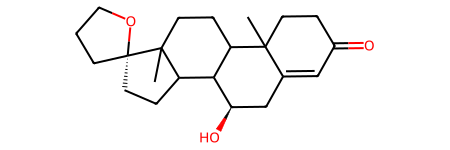

In [330]:
AllChem.MolFromSmiles(df.loc[0,'smiles'])

### first product

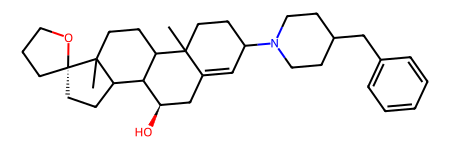

In [331]:
AllChem.MolFromSmiles(df.loc[0,'PRODUCT_FINAL'])